In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch
%matplotlib inline
import matplotlib.pyplot as plt
from dnaDataloader import expermentDataloader
from dnaModelUtil import RNNModel
from dnaDataloader import addData
from dnaDataloader import expermentDataloader
from torch.utils.data import DataLoader
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
oneMinInFPS = 1200
batch_size = 10
num_workers = 0
movieRuntime = 5
device

device(type='cuda', index=1)

## Torch RNN

Looks like torch RNN model handles most of the internal workings of a RNN model. 

<em>Parameters</em>:
  <ul>
    <li> <p>input_size – The number of expected features in the input x </li>
    <li> <p>hidden_size – The number of features in the hidden state h </li>
    <li> <p>num_layers – Number of recurrent layers. 
    <br>E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1 </li>
    <li> <p>nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh' </li>
    <li> <p>bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True </li>
    <li> <p>batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False 
    <li> <p>dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0 </li>
    <li> <p>bidirectional – If True, becomes a bidirectional RNN. Default: False </li>
  </ul>

$ h_t = \tanh(x_t W_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh}) $

where:

<br>N = batch size 
<br>L = sequence length
<br>D = 2 if bidirectional=True otherwise 1 
<br>$H_{in}$ = input_size 
<br>$H_{out}$ = hidden_size 


In [4]:
oneTimeUnitInFPS = oneMinInFPS
totalRuntime = movieRuntime*oneMinInFPS
folder = '/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted/1800_nM_AR_5000'

data = expermentDataloader(
    f"{folder}/index.csv",
    f"{folder}", 
    length = oneTimeUnitInFPS,
)
targets = [i[1] for i in data]
timeSlices = []
for startTime in range(0, totalRuntime, oneTimeUnitInFPS):
    data = expermentDataloader(
        f"{folder}/index.csv",
        f"{folder}", 
        length = oneTimeUnitInFPS,
        start=startTime
    )
    timeSlices.append([np.array(i[0]) for i in data])
rawInput = list(zip(*timeSlices))
rawInput = [np.array(i) for i in rawInput]
print(f"Number of experments: {len(rawInput)}")
print(f"Number of time steps: {len(rawInput[0])}")
print(f"Number of frames per time step: {len(rawInput[0][0])}")
print(f"One fame: {rawInput[0][0][0]}")
print(f"Total inputs: {len(rawInput)}, targets: {len(targets)}")
rawData = list(zip(rawInput,targets))
rawData[0]

Number of experments: 888
Number of time steps: 5
Number of frames per time step: 1200
One fame: 0
Total inputs: 888, targets: 888


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([144]))

In [5]:
type(rawData[0][0][0][0])

numpy.int64

In [6]:
featIn = len(rawData[0][0][0])
featIn

1200

In [7]:
trainValidData = []
testData = []
addData(testData, trainValidData, rawData, rhsSize=300)


np.random.shuffle(trainValidData)
trainData = []
validData = []
addData(trainData, validData, trainValidData, rhsSize=int(len(trainValidData)*(1/3)))

trainDataset = DataLoader(trainData, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True) 
validDataset = DataLoader(validData, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
testDataset = DataLoader(testData, batch_size=len(testData), shuffle=True, num_workers=num_workers, pin_memory=True)
print(f"Training dataset size: {len(trainData)}")
print(f"Valid dataset size: {len(validData)}")
print(f"Testing dataset size: {len(testData)}")
print(f"Total: {len(trainData) + len(validData) + len(testData)}")
print(f"number train batches:{len(trainDataset)}")
print(f"number valid batches:{len(validDataset)}")
print(f"number test batches:{len(testDataset)}")

Training dataset size: 200
Valid dataset size: 100
Testing dataset size: 588
Total: 888
number train batches:20
number valid batches:10
number test batches:1


<em>Inputs:</em> input, h_0

<em>input</em>: tensor of shape $ L, H_{in} $ for unbatched input, or batched input as $ (L, N, H_{in}) $ <br>
when <em>batch_first=False</em> or $(N, L, H_{in})$ when <em>batch_first=True</em>. <br>
The input can also be a packed variable length sequence. <br>
See <em>torch.nn.utils.rnn.pack_padded_sequence</em> or <br>
<em>torch.nn.utils.rnn.pack_sequence</em> for details.

<em>h_0</em>: tensor of shape $(D * \text{num\_layers}, H_{out})$ for unbatched input or <br>
$(D * \text{num\_layers}, N, H_{out})$ for batched containing the initial hidden <br>
state for the input sequence batch. <br>
<b>Defaults to zeros if not provided</b>.

where:
<br> N = batch size 
<br> L = sequence length 
<br> D = 2 if bidirectional=True otherwise 1 
<br> $H_{in}$ = input_size 
<br> $H_{out}$ = hidden_size 

In [8]:
model = RNNModel(featIn=oneTimeUnitInFPS, capacity=int(featIn*0.25), hiddenLayers=4).to(device)
MSE = nn.MSELoss(reduction = 'sum')
adam = torch.optim.Adam(model.parameters(),lr=0.00001,weight_decay=1e-5)
epochs = 1000
em = 20
trainDataset
validDataset
losses = []
accs = []
losses_t = []
accs_t = []
print("training...")
for e in range(epochs): 
    avgLossTrain = []
    currentAccTrain = []
    model.train()
    for i, (inputs, targets) in enumerate(trainDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        avgLossTrain.append(float(loss.item()))
        adam.zero_grad()
        loss.backward()
        adam.step()
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.item()
        currentAccTrain.append(float(totalCorrect/len(targets)))
    accs_t.append(float(np.sum(currentAccTrain)/len(currentAccTrain)))
    losses_t.append(float(np.sum(avgLossTrain)/len(avgLossTrain)))
        
    avgLoss = []
    currentAcc = []
    model.eval()
    for i, (inputs, targets) in enumerate(validDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        avgLoss.append(float(loss.clone().detach().cpu().numpy()))
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        print(f"\
        epoch: {e}/{epochs}\t \
        Train Loss:{'%.4f' % (np.sum(avgLossTrain)/len(avgLossTrain))} Valid Loss:{'%.4f' % (np.sum(avgLoss)/len(avgLoss))}\t \
        Train accuracy:{'%.2f' % (np.sum(currentAccTrain)/len(currentAccTrain))} Valid accuracy:{'%.2f' % (np.sum(currentAcc)/len(currentAcc))} \
        ",end="\x1b\r")
    accs.append(float(np.sum(currentAcc)/len(currentAcc)))
    losses.append(float(np.sum(avgLoss)/len(avgLoss)))

training...


KeyboardInterrupt: 

Best acc: 0.5599999999999999


10000

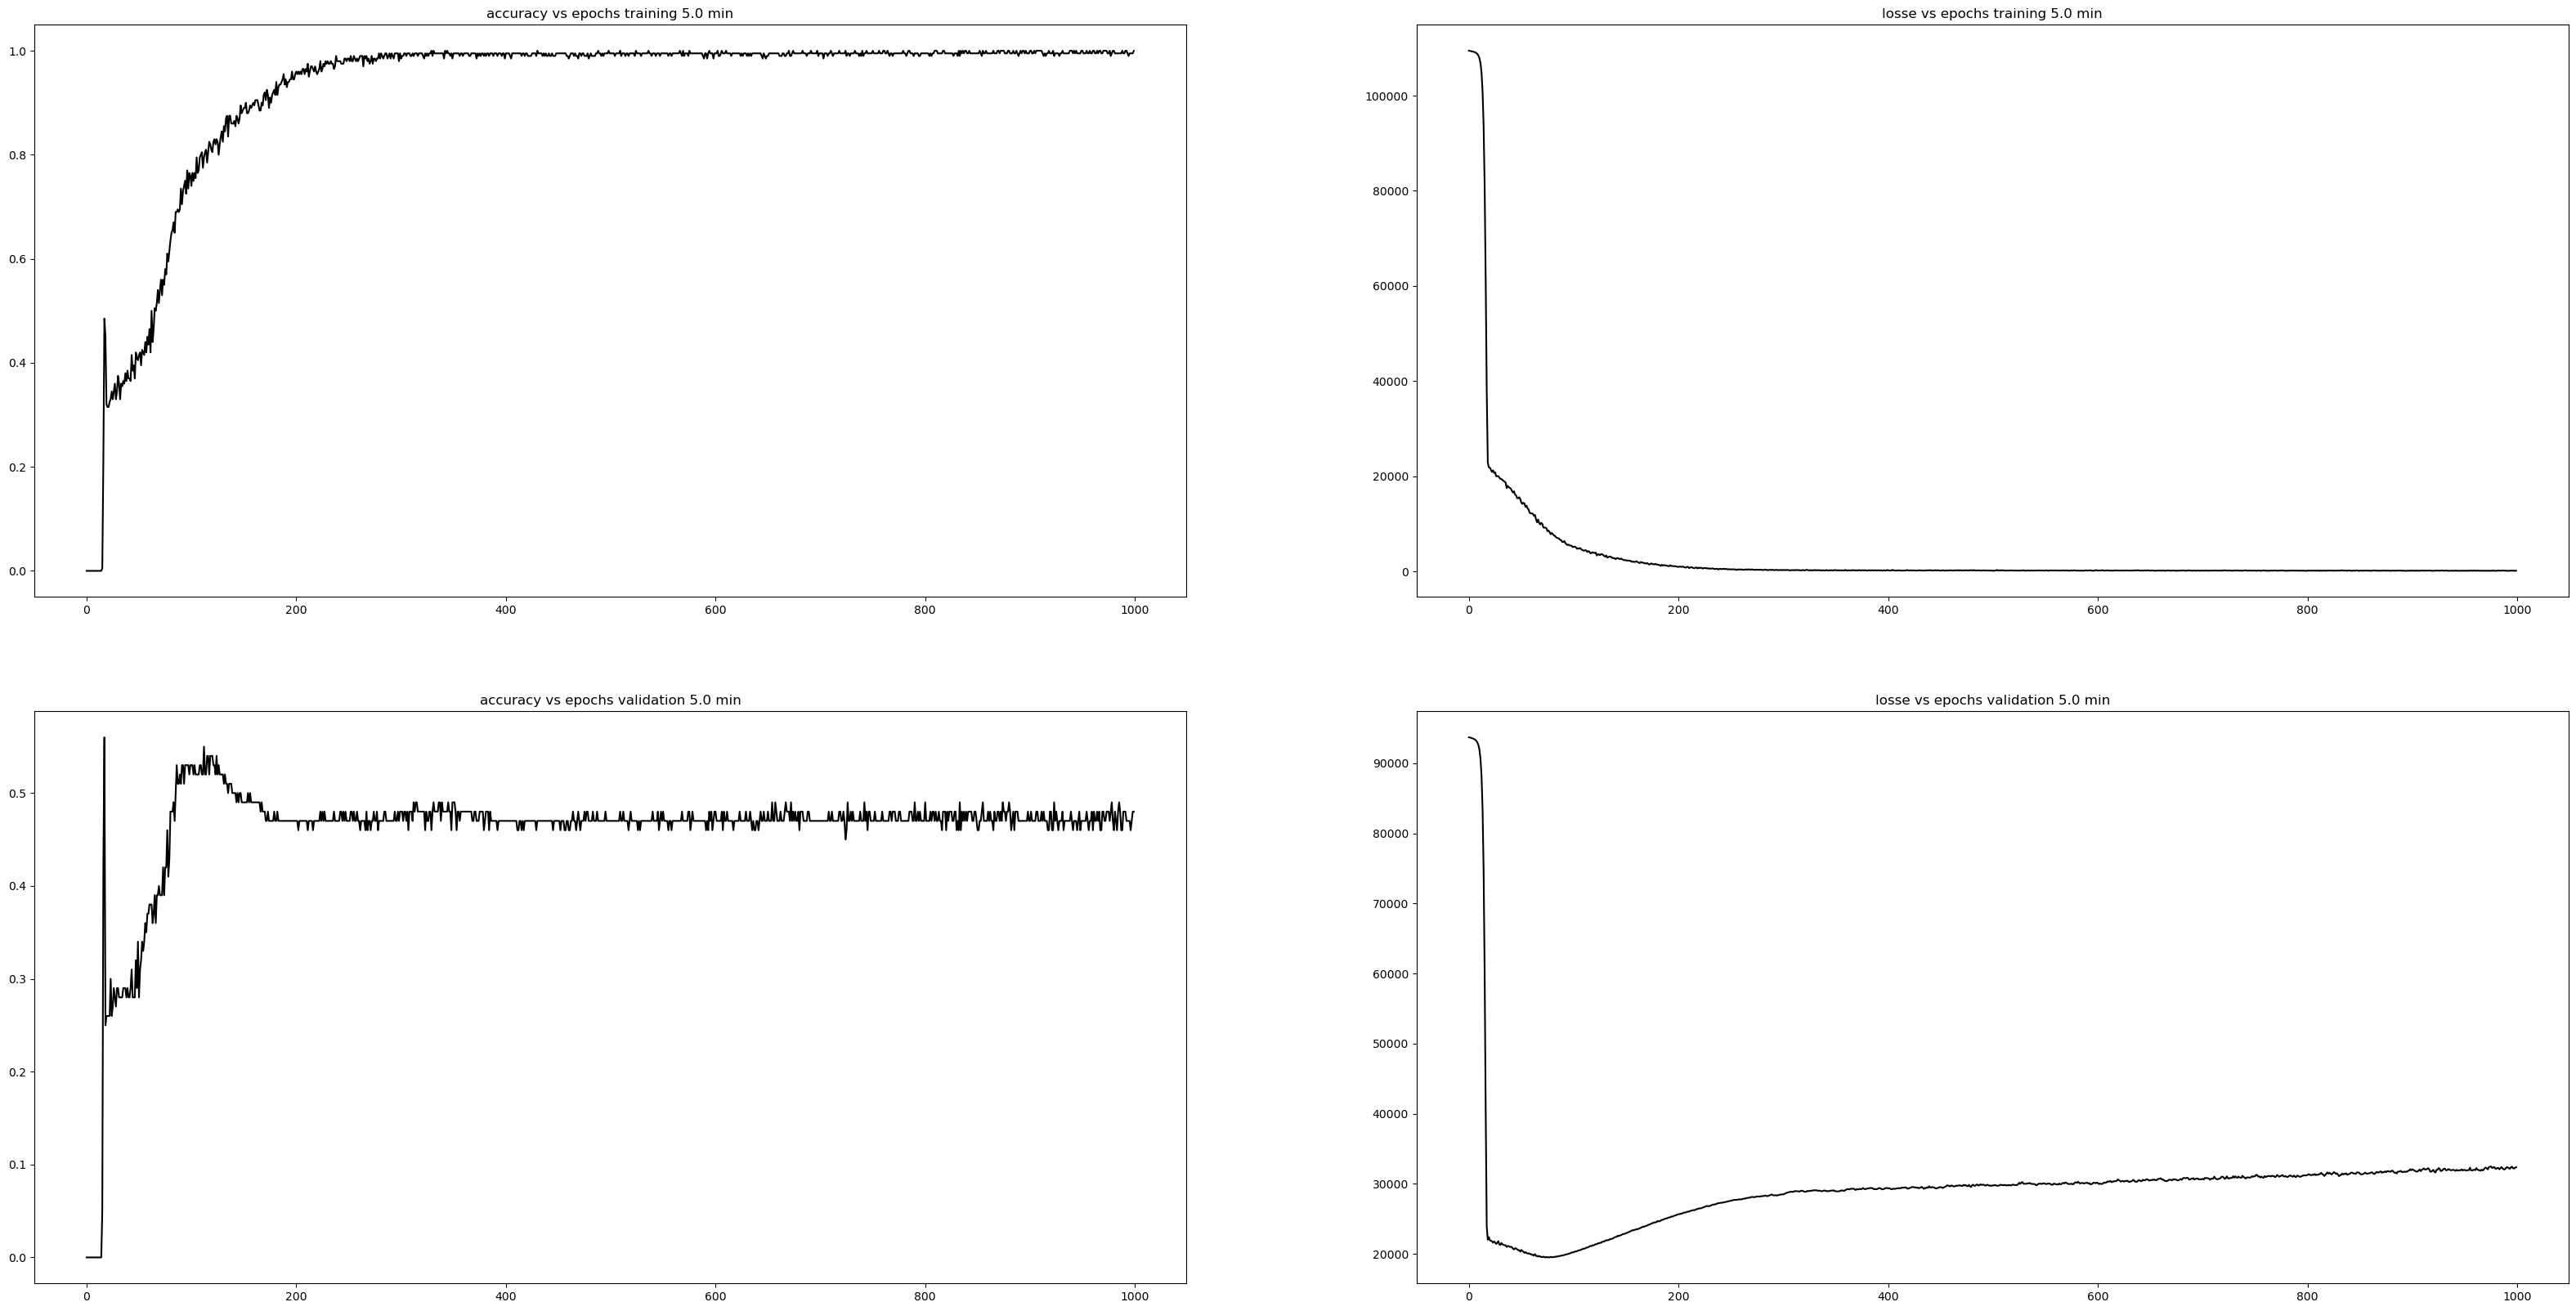

In [9]:
defultePlotSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [40, 20]

plt.subplot(2, 2, 1)
plt.title(f'accuracy vs epochs training {totalRuntime/oneMinInFPS} min')
plt.plot(list(range(len(accs_t[:]))), accs_t[:], '-', color='black', )
plt.subplot(2, 2, 2)
plt.title(f'losse vs epochs training {totalRuntime/oneMinInFPS} min')
plt.plot(list(range(len(losses_t)))[:], losses_t[:], '-', color='black')

plt.subplot(2, 2, 3)
plt.title(f'accuracy vs epochs validation {totalRuntime/oneMinInFPS} min')
plt.plot(list(range(len(accs[:]))), accs[:], '-', color='black', )
plt.subplot(2, 2, 4)
plt.title(f'losse vs epochs validation {totalRuntime/oneMinInFPS} min')
plt.plot(list(range(len(losses)))[:], losses[:], '-', color='black')
plt.rcParams['figure.figsize'] = defultePlotSize
print(f"Best acc: {max(accs)}")

epochs*len(validDataset)